In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage
import torch
import torch.nn.functional as func

In [18]:
# name = "T_S04856"
# name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [19]:
clusters = 10

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [21]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [22]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

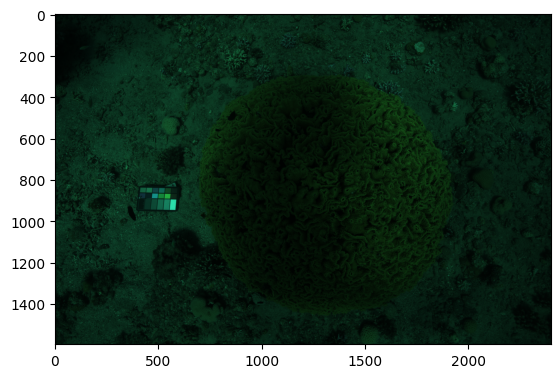

In [23]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

In [24]:
png.dtype

dtype('float64')

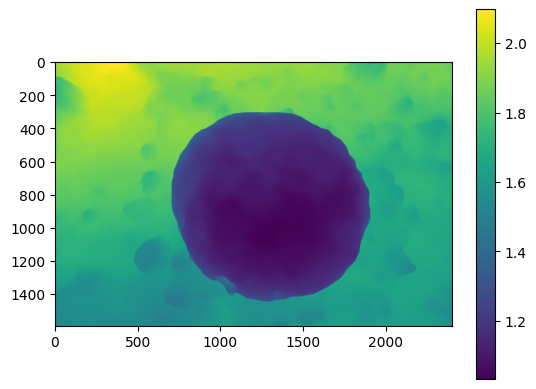

In [25]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [26]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [27]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [28]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

In [29]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

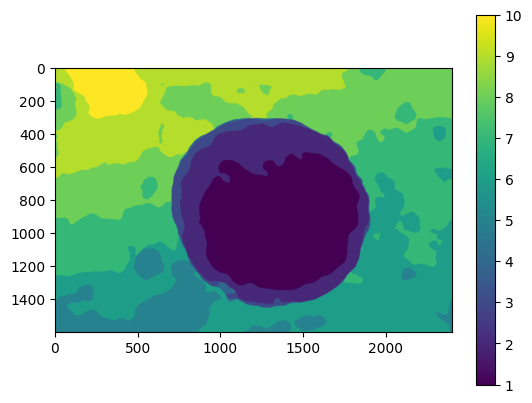

In [30]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [31]:
np.unique_counts(labels)

UniqueCountsResult(values=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8), counts=array([624129, 367726,  80555,  11589, 263087, 699030, 563987, 637811,
       473182, 109304]))

In [32]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    pixel_means = pixels.mean(axis=1)
    idx = np.argsort(pixel_means)[:int(round(float(len(pixel_means)) * 0.01))]
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())
    # break

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [33]:
idx

array([44841, 44842, 59397, ..., 11092, 30904, 58520], shape=(1093,))

In [34]:
len(idx) / pixels.shape[0]

0.009999634048159262

In [35]:
pixels <= np.percentile(pixels, 1, axis=0), pixels[0],  np.percentile(pixels, 1, axis=0)

(array([[False, False,  True],
        [False, False,  True],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]], shape=(109304, 3)),
 array([0.02352941, 0.03137255, 0.00392157]),
 array([0.01960784, 0.02745098, 0.00392157]))

In [36]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [37]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.01, (38304,))

In [38]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [39]:
z_values

array([1.03710938, 1.03710938, 1.03710926, ..., 2.0703125 , 1.99540734,
       1.99534512], shape=(38304,))

In [40]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [41]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z) - B_hat

In [42]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), loss='soft_l1', bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [43]:
# dsssdfsd

In [44]:
dark_pixels

array([[0.        , 0.00392157, 0.        ],
       [0.        , 0.00392157, 0.        ],
       [0.        , 0.00392157, 0.        ],
       ...,
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157]], shape=(38304, 3))

In [45]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.57743432 3.47951326 0.75181914 4.00042253]
0.6205524971605222 [1.00000000e+00 7.24255392e-03 9.00073816e-33 4.99999991e+00]
[0.35919956 2.88845694 0.26507031 0.17717342]
0.6205524971610669 [9.99999999e-01 7.24255521e-03 1.66980512e-35 4.95092346e+00]
[0.97823209 1.43032177 0.13869277 1.1388807 ]
0.6205524971605109 [1.00000000e+00 7.24255407e-03 1.70456683e-38 4.99231005e+00]
[0.10957175 1.469727   0.266124   4.57289637]
0.6205524971762598 [9.99999989e-01 7.24255981e-03 6.30427613e-31 4.99347027e+00]
[0.44914606 2.36772955 0.94256619 4.04594695]
0.6205524971607378 [1.00000000e+00 7.24255482e-03 6.22064596e-34 4.99999213e+00]
[0.13829394 0.92962808 0.25615193 0.26759294]
0.6205524971605141 [1.00000000e+00 7.24255396e-03 3.22764334e-35 4.96999274e+00]
[0.56801621 2.9143894  0.82264891 0.56607989]
0.6205524971605184 [1.00000000e+00 7.24255416e-03 9.28857046e-32 4.99999019e+00]
[0.49394826 2.94730506 0.80571464 2.53824448]
0.620552497160521 [1.00000000e+00 7.24255393e-03 4.93930026e-33 4

(array([1.00000000e+00, 7.24255407e-03, 1.70456683e-38, 4.99231005e+00]),
 np.float64(0.6205524971605109))

In [46]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.3840285  1.51925273 0.10317676 2.85176878]
0.8058074199560323 [1.00000000e+00 1.16322407e-02 5.43755459e-28 4.96750616e+00]
[0.40668504 2.98350995 0.64663079 1.20148587]
0.8058074199580069 [9.99999999e-01 1.16322380e-02 9.55579266e-33 4.99991892e+00]
[0.91944593 3.2127808  0.25932762 2.94494861]
0.8058074199581615 [9.99999999e-01 1.16322380e-02 1.13953792e-29 4.99455612e+00]
[0.41996238 1.65437511 0.00244372 1.88532897]
0.8058074199564658 [1.00000000e+00 1.16322364e-02 4.52776798e-31 4.93690436e+00]
[0.07209254 1.46232898 0.30687104 4.21223895]
0.8058074199697 [9.99999990e-01 1.16322404e-02 2.37469107e-34 4.97672423e+00]
[0.73492119 2.16885946 0.57716111 1.52355481]
0.8058074199566655 [1.00000000e+00 1.16322359e-02 2.85394092e-30 4.97946926e+00]
[0.87487628 3.85652915 0.16000793 1.67249278]
0.8058074199609366 [9.99999996e-01 1.16322389e-02 1.76224640e-27 4.98824508e+00]
[0.91803304 0.67626668 0.84866491 3.31781278]
0.8058074199560049 [1.00000000e+00 1.16322405e-02 5.40827928e-41 4.9

(array([1.00000000e+00, 1.16322405e-02, 5.40827928e-41, 4.99999013e+00]),
 np.float64(0.8058074199560049))

In [47]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.1181224  3.65112707 0.07160752 3.70888715]
0.3247438682862368 [1.00000000e+00 1.61566174e-03 1.01686250e-93 4.99585301e+00]
[0.08276518 3.81614978 0.94016307 3.00963037]
0.32474386828655843 [9.99999990e-01 1.61566165e-03 3.46593937e-98 4.99199200e+00]
[0.49278168 0.1387225  0.8380722  3.8991682 ]
0.3247438682863378 [9.99999996e-001 1.61566164e-003 1.05907921e-101 4.99628376e+000]
[0.51340375 4.33551079 0.80971223 2.65124849]
0.3247438682862216 [1.00000000e+00 1.61566170e-03 1.32878842e-96 4.99863988e+00]
[0.01933048 2.1180812  0.94839497 2.08186732]
0.3247438683177368 [9.99999962e-01 1.61564644e-03 3.73788104e-97 4.95851240e+00]
[0.61820097 1.93869015 0.54108547 0.50157015]
0.3247438682863349 [9.99999996e-01 1.61566164e-03 5.73825061e-91 4.99962213e+00]
[0.68223617 2.82104723 0.28790523 4.49785339]
0.32474386828642726 [9.99999994e-01 1.61566160e-03 9.82208538e-92 4.99968346e+00]
[0.11022802 2.60683794 0.92696164 1.00560135]
0.3247438682862136 [1.00000000e+00 1.61566167e-03 6.9758878

(array([1.00000000e+00, 1.61566167e-03, 6.97588781e-94, 4.99481715e+00]),
 np.float64(0.3247438682862136))

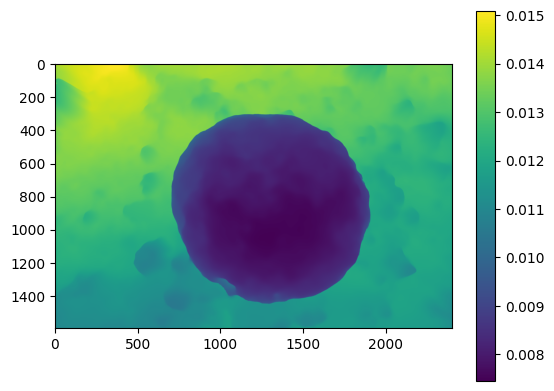

In [48]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

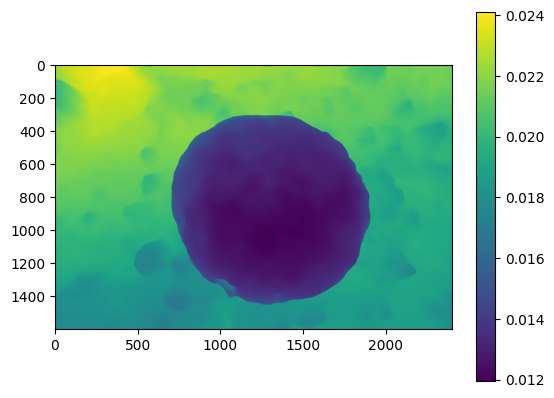

In [49]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

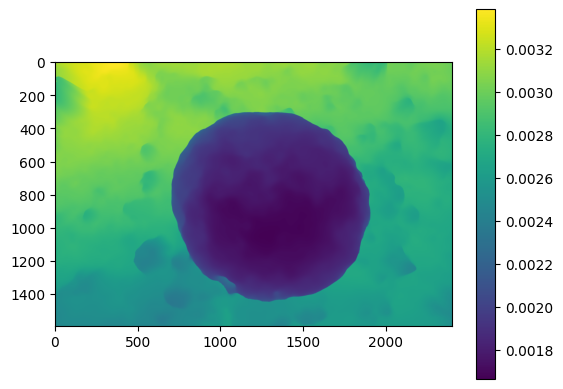

In [50]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

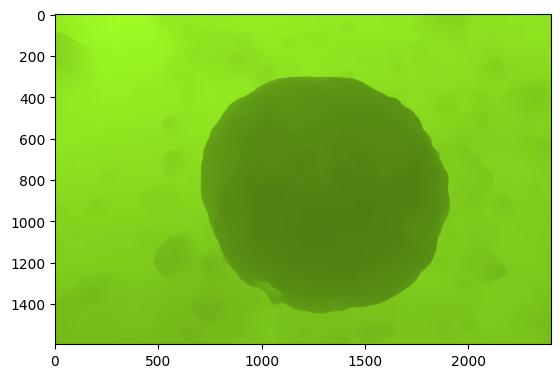

In [51]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

In [52]:
png

array([[[0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04313725, 0.00784314],
        ...,
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784]],

       [[0.02352941, 0.03921569, 0.00784314],
        [0.02352941, 0.03529412, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784]],

       [[0.02352941, 0.03529412, 0.00392157],
        [0.01960784, 0.03137255, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784]],

       ...,

       [[0.04705882, 0.0745098 , 0.01176471],
        [0.04313725, 0.0745098 , 0.01568627],
        [0.03137255, 0

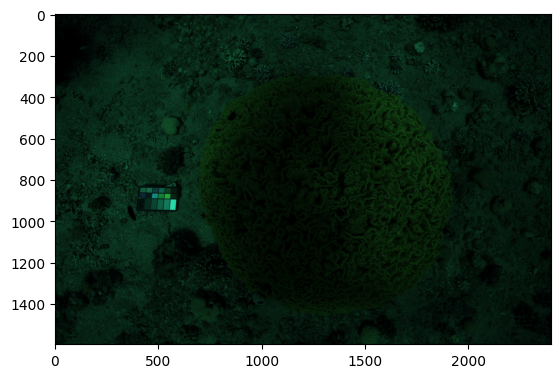

In [53]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

direct_signal = np.clip(direct_signal, 0, 1)

imshow(direct_signal, color_channel="bgr")

In [54]:
direct_signal

array([[[0.01339426, 0.02457873, 0.00469011],
        [0.01339426, 0.02457873, 0.00469011],
        [0.01338871, 0.02064831, 0.00468886],
        ...,
        [0.04547491, 0.07276536, 0.01661448],
        [0.04547687, 0.07276848, 0.01661492],
        [0.04548227, 0.07277707, 0.01661614]],

       [[0.0094727 , 0.0167356 , 0.00469011],
        [0.0094727 , 0.01281403, 0.00076854],
        [0.00946714, 0.01280517, 0.00076729],
        ...,
        [0.04547491, 0.07668693, 0.01661448],
        [0.04547687, 0.07669005, 0.01661492],
        [0.04548227, 0.07669864, 0.01661614]],

       [[0.00947533, 0.01281823, 0.00076914],
        [0.00555377, 0.00889666, 0.00076914],
        [0.00946993, 0.01280962, 0.00076792],
        ...,
        [0.04155327, 0.07276525, 0.01661447],
        [0.04155806, 0.07277287, 0.01661555],
        [0.04156095, 0.07277748, 0.0166162 ]],

       ...,

       [[0.0360652 , 0.0569119 , 0.00930172],
        [0.03214364, 0.0569119 , 0.01322329],
        [0.02037788, 0

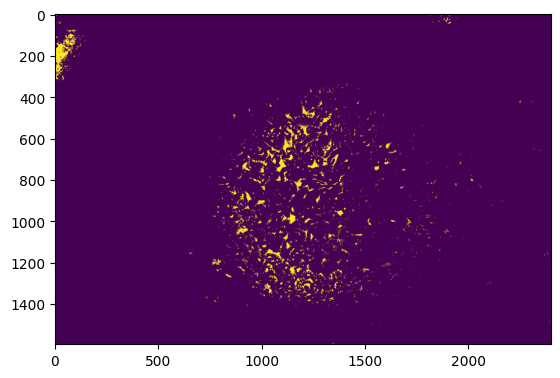

In [55]:
plt.imshow((png < backscatter)[:, :, 0])

In [56]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [57]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [58]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [59]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [60]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 4, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)

    return direction

In [61]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 4) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(100):
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

torch.Size([1598, 2402, 3])

In [62]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

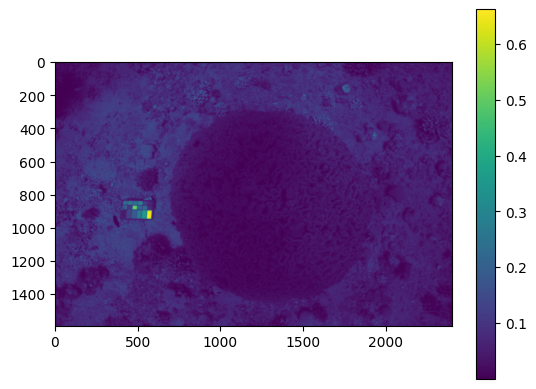

In [63]:
imshow(a_values[:, :, 0])

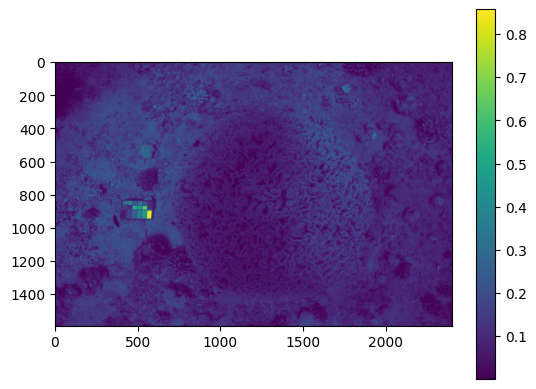

In [64]:
imshow(a_values[:, :, 1])

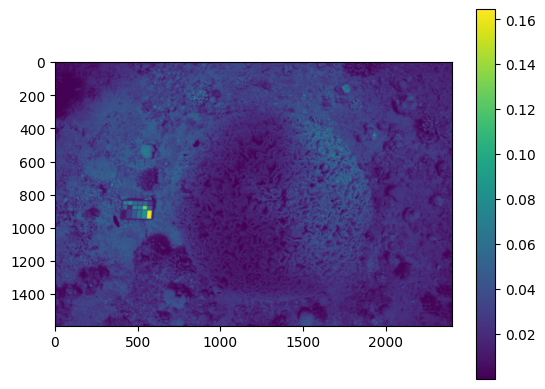

In [65]:
imshow(a_values[:, :, 2])

1.7155204


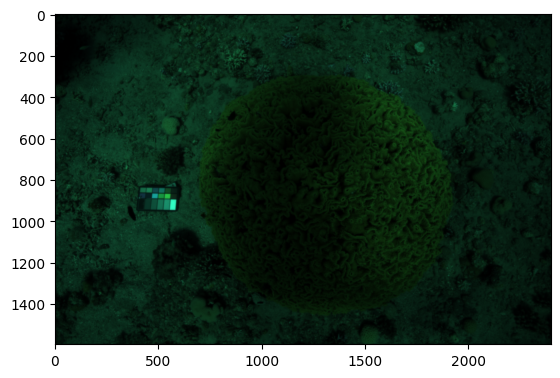

In [66]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

In [67]:
np.sort(local_illuminant_map.flatten()), (local_illuminant_map[:, :, 0] <= 0).mean()

(array([5.9687220e-09, 6.4620931e-09, 7.0065678e-09, ..., 1.7140619e+00,
        1.7149191e+00, 1.7155204e+00], shape=(11491200,), dtype=float32),
 np.float64(0.0))

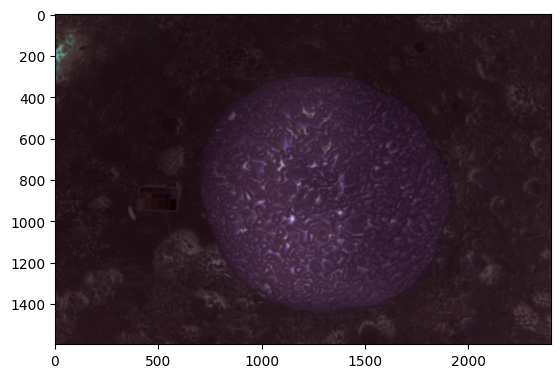

In [68]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

beta_min = beta_d_coarse.min()
beta_max = beta_d_coarse.max() - beta_min
imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")

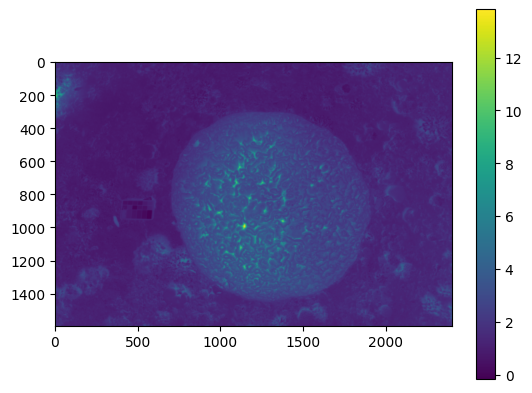

In [69]:
imshow(beta_d_coarse[:, :, 0])

In [70]:
np.sort(beta_d_coarse[:, :, 0].flatten()), np.isnan(beta_d_coarse[:,:,0].flatten()).mean(), (beta_d_coarse[:,:,0].flatten() < 0).mean()

(array([-0.16135822, -0.1613065 , -0.16115145, ..., 13.783914  ,
        13.798876  , 13.830997  ], shape=(3830400,), dtype=float32),
 np.float64(0.0),
 np.float64(0.00039865288220551376))

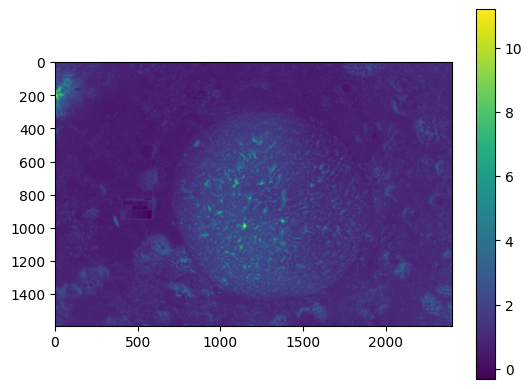

In [71]:
imshow(beta_d_coarse[:, :, 1])

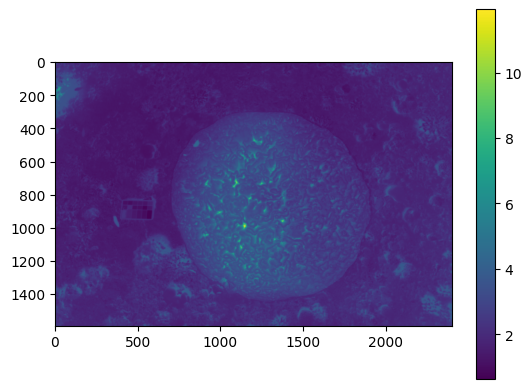

In [72]:
imshow(beta_d_coarse[:, :, 2])

### Refined Estimate of $\beta_c^D(z)$

In [73]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [74]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [75]:
def leastsquares_compute_beta_D(local_illuminant_map: np.ndarray, depths: np.ndarray, color_channel: int, starts=50):
    lo = np.array([0, -np.inf, 0, -np.inf])
    hi = np.array([np.inf, 0, np.inf, 0])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4) * 2000
        starting_point[1] /= -10
        starting_point[3] /= -10

        print(starting_point)

        try:
            result = least_squares(optimize_compute_beta_D, starting_point, args=(local_illuminant_map[:, :, color_channel], depths), bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        result = optimize_compute_beta_D(params, local_illuminant_map[:, :, color_channel], depths)
        max_diff = np.abs(result).max()
        loss = np.linalg.norm(result)

        print(loss, max_diff, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [76]:
local_illuminant_params_b, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 0)

local_illuminant_params_b, loss #0.282

[ 183.89123146 -191.14822009 1047.92619058  -52.20909552]
5194970135.659732 100852529.96964741 [ 1.83891231e+02 -1.24156931e+14  8.98057412e+37 -4.99704894e+01]
[  28.81316152 -115.2873876  1336.24050688 -175.63188738]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:141: RuntimeWarning: invalid value encountered in scalar multiply
  alpha = max(0.001 * alpha_upper, (alpha_lower * alpha_upper)**0.5)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in square
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/chris/.cache/

3.180126437301478e+105 1.0067024775597616e+104 [  28.81316152 -115.2873876  1336.24050688 -175.63188738]
[ 311.62474289  -78.83341755 1518.37060766   -2.57241111]
980.6608340892844 11.348154425095618 [311.62474289 -67.32440891  13.59482867  -1.3014226 ]
[ 275.68224323  -53.07567316  656.90708023 -146.68802999]
6683180120.057972 133490127.41819885 [ 7.73495076e+39 -5.22282867e+01  6.56907080e+02 -1.46688030e+02]
[1447.38266499   -8.98184348  336.92574203  -74.97118947]
980.7906568105188 11.361155806120747 [ 14.05294323  -1.3210681  336.92574203 -74.97118947]
[472.88772373 -26.01478678 309.2185298   -4.67097625]
980.6608340892724 11.348154484583949 [ 1.07592008e+01 -1.56196739e+03  1.35948305e+01 -1.30142268e+00]
[1281.16656445  -74.19064854 1070.57747301  -14.37046127]
980.6608340905952 11.34815618573183 [ 1.28116656e+03 -1.59367332e+03  1.35948800e+01 -1.30142485e+00]
[1110.72266957 -166.39906956  324.57739791 -176.51795868]
2.4637176080881253e+150 9.572878916967352e+148 [1110.72266957

/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = phi / phi_prime
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  p *= Delta / norm(p)
/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:166: RuntimeWarning: invalid value encountered in multiply
  p *= Delta / norm(p)


6.940649794708874e+56 1.567555770890243e+55 [1806.24695626  -63.68578006 1003.93116886 -162.90972858]
[1129.29820292 -177.70025954  966.85201335  -10.8434933 ]
980.6608340893472 11.348155007383331 [ 1.12929820e+03 -3.53173882e+06  1.35948463e+01 -1.30142337e+00]
[1117.06429563 -155.76942028 1042.13146779 -180.13927431]
5.265724174259498e+140 1.970904090128028e+139 [1117.06429563 -155.76942028 1042.13146779 -180.13927431]
[263.5202176  -50.75470085 116.75801579 -96.29143483]
6575605269.030802 127384868.9950038 [ 5.05057813e+37 -4.98074515e+01  1.16758016e+02 -9.62914348e+01]
[ 681.46462027 -191.53859854 1679.92759523  -68.67657981]
2.923052342131795e+60 6.90498871675875e+58 [  681.46462027  -191.53859844 14440.88433035   -68.67657981]
[786.17607728  -3.38215685 545.88806924 -27.64655415]
980.6731982517434 11.34912964059101 [ 13.73566494  -1.3073969  504.73814937 -73.30273382]
[1324.1276227  -102.92772207 1884.66742875  -35.19373431]
3097.3427200730816 9.591402416361964 [ 1.32412762e+03 

/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale


[1074.96314966 -126.43138245 1301.10924397  -14.79058885]
980.6608340892731 11.348154480815193 [ 1.07496315e+03 -3.30114781e+06  1.35948304e+01 -1.30142267e+00]
[ 719.647955   -153.12074547 1304.72756699 -181.66906205]
3.188575583720995e+138 1.1819729739622933e+137 [ 719.647955   -153.12074547 1304.72756699 -181.66906205]
[ 583.73996631 -186.66947838 1684.02554561  -33.6595228 ]
11937007096.49106 154492112.22875258 [ 5.83739966e+02 -6.37302703e+15  1.04337499e+18 -2.82920651e+01]
[ 508.73052896  -87.67774319 1472.42605386  -25.21506906]
1052.279248905175 11.239828307873811 [ 3.27842566e+01 -1.80324193e+00  8.64403885e+00 -3.48259022e+08]
[  62.04999142  -80.77576012 1939.33327606 -159.05609586]
6.524729509641037e+73 1.6931795023979723e+72 [  62.04999142  -80.77576012 1939.33327606 -159.05609586]
[1904.39380221 -182.83919347 1636.88812137 -183.30324227]
[1470.94044979 -125.36222134  190.58269602  -68.99091802]


/home/chris/.cache/pypoetry/virtualenvs/pyaqua3ddev--DOk9sNS-py3.12/lib/python3.12/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: invalid value encountered in scalar divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


4.8478413115412147e+61 1.148268147112148e+60 [1470.94044979 -125.36222134 1679.12972192  -68.99091802]
[ 726.40587312  -23.26400412 1402.15908197  -46.31024979]
141060.96197576865 1468.7534296931544 [ 5.55621858e+16 -2.13822874e+01  1.40215908e+03 -4.63102498e+01]
[1659.66150113 -191.58340561 1958.52473804  -72.47896974]
1.4563004766473663e+63 3.550479045856739e+61 [ 1.65966150e+03 -1.91583403e+02  8.17621357e+04 -7.24789697e+01]
[1945.85307804  -77.42331108  208.84888029 -135.09346959]
1.8817152762924765e+69 4.7660749411993874e+67 [1945.85307804  -77.42331108  208.84888029 -135.09346959]
[ 172.12037639  -33.4211873  1815.40417961  -70.26395788]
10678705762.345278 153798914.23755112 [ 8.41590144e+21 -3.25781119e+01  1.81540418e+03 -7.02639579e+01]
[ 560.84909376  -18.43502628 1816.51525538  -85.34153978]
3040.3361689429494 9.891505976862582 [ 8.36968126e+15 -1.81871615e+01  1.81651526e+03 -8.53415398e+01]
[1355.62849802  -80.37300616 1896.73119035   -3.20509455]
980.6608340892608 11.34

(array([ 5.66818788e-01, -3.53197330e-13,  2.40668493e+01, -1.94579456e+00]),
 np.float64(975.7813347039391))

In [77]:
local_illuminant_params_g, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 1)

local_illuminant_params_g, loss # 0.407

[ 799.30064361 -168.94056531 1279.99286844 -136.92583986]
2.6998105753939385e+123 9.764749043713269e+121 [ 799.30064361 -168.94056531 1279.99286844 -136.92583986]
[ 562.04396515 -136.47497137 1670.01280623  -25.36635842]
3197.231315797334 15.608137377852184 [ 5.62043965e+02 -2.86563226e+12  4.66614845e+17 -2.03753971e+01]
[1531.67502322  -56.7070904   436.43894355 -130.25647474]
6268978096.522213 134762824.89025623 [ 8.70021483e+42 -5.56684077e+01  4.36438944e+02 -1.30256475e+02]
[1386.31150744 -175.00004065   25.43583651 -165.71588507]
2.066272667931517e+151 8.316682689062067e+149 [1386.31150744 -175.00004065   25.43583651 -165.71588507]
[ 900.7724582   -39.12086318  589.97202559 -139.72203722]
6744613405.909923 112281171.53948547 [ 1.31268380e+27 -3.82148948e+01  5.89972026e+02 -1.39722037e+02]
[ 423.15545583  -90.555713   1975.8705588   -88.55723846]
2.391215527951109e+78 6.783954701554431e+76 [ 3385.22760223   -90.555713   15806.96507139   -88.55723846]
[ 262.66824523 -103.99439556

/tmp/ipykernel_267424/1999039822.py:4: RuntimeWarning: divide by zero encountered in divide
  z_hat = -np.log(E) / beta_D


3083.2334045178077 5.30759670315021 [ 3.54255863e+01 -1.30142307e+16  6.38320611e+22 -2.55985000e+01]
[1110.64923463  -92.57138838   97.78544242 -112.88751437]
1.5115454656596863e+83 4.397030204508917e+81 [1110.64923463  -92.57138838   97.78544242 -112.88751437]
[ 257.47425885   -6.71324836  333.76215627 -130.37637248]
1306.4112968015388 14.668133258624547 [   6.13165331   -0.9610705   333.76215627 -130.37637248]
[1003.12810447 -107.24514894  349.05074354  -48.58544255]
8.57896055243143e+17 1.6307891251175242e+16 [ 1.00312810e+03 -4.12638872e+14  1.61322853e+26 -4.61747262e+01]
[ 245.93998165 -150.26566062 1912.70456174 -120.17354931]
1.06295150127227e+108 3.5761904392525896e+106 [ 245.93998165 -150.26566062 1912.70456174 -120.17354931]
[1702.66498225 -115.73522665  886.04454635  -70.37436509]
4.19880544402475e+62 1.0425296161152828e+61 [1702.66498225 -115.73522665 2808.96108041  -70.37436509]
[ 508.38749002  -72.74828784 1014.42281477 -187.90153694]
3.308658081401159e+65 8.37815825548

(array([ 2.26371741e+01, -2.56178072e+04,  6.13082712e+00, -9.60991911e-01]),
 np.float64(1306.4112955053774))

In [78]:
local_illuminant_params_r, loss = leastsquares_compute_beta_D(local_illuminant_map, tif, 2)

local_illuminant_params_r, loss # 0.205

[415.42785573 -57.80937725  53.61586305  -8.30515506]
674.4217954282508 5.247190971739598 [ 2.69018691e+03 -9.76212542e+05  8.35407661e+00 -8.50153726e-01]
[ 238.83911812 -151.264555    719.01748034  -93.48134679]
2.9676667582489716e+84 7.86314208124329e+82 [ 238.83911812 -151.264555    719.01748034  -93.48134679]
[ 346.00974148  -91.29324109 1828.6727553  -186.26434069]
6.343968722209909e+82 1.6589084450504329e+81 [ 346.00974148  -91.29324109 1828.6727553  -186.26434069]
[1279.92986258 -131.44853223 1878.47645637  -77.64790712]
4.740257233330944e+69 1.1319526846719423e+68 [1279.92986258 -131.44853223 1878.47645637  -77.64790712]
[ 549.76235187 -144.52207274  565.29621231  -73.73278888]
9.782556858840606e+64 2.2682965737591646e+63 [  549.76235187  -144.52207245 25418.69074418   -73.73278888]
[889.46686393 -57.14476068 508.16091683 -88.75034136]
6926416320.444567 136895434.66518053 [ 4.47869116e+43 -5.61994981e+01  5.08160917e+02 -8.87503414e+01]
[ 579.64120104 -115.46856675  183.487434

(array([ 2.69018691e+03, -9.76212542e+05,  8.35407661e+00, -8.50153726e-01]),
 np.float64(674.4217954282508))

In [79]:
# local_illuminant_params_b = np.array([40.36737389, -5.24498546, 40.36737389, -5.24498546])
# local_illuminant_params_g = np.array([51.71813242, -4.92373242, 51.71813242, -4.92373242])
# local_illuminant_params_r = np.array([53.08643292, -5.8253201 , 53.08643292, -5.8253201 ])

In [80]:
b_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 0], tif)).mean()
g_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 1], tif)).mean()
r_loss = np.abs(optimize_compute_beta_D(local_illuminant_params_b, local_illuminant_map[:, :, 2], tif)).mean()

b_loss, g_loss, r_loss

(np.float64(0.35017766519485954),
 np.float64(0.6345641216544103),
 np.float64(0.45649046701917667))

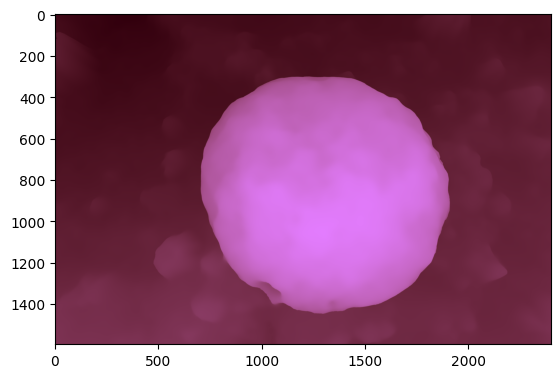

In [81]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(local_illuminant_params_b[0], local_illuminant_params_b[1], local_illuminant_params_b[2], local_illuminant_params_b[3], tif)
beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

beta_d_min = beta_d.min()
beta_d_max = beta_d.max() - beta_d_min
imshow((beta_d - beta_d_min) / beta_d_max, color_channel="bgr")

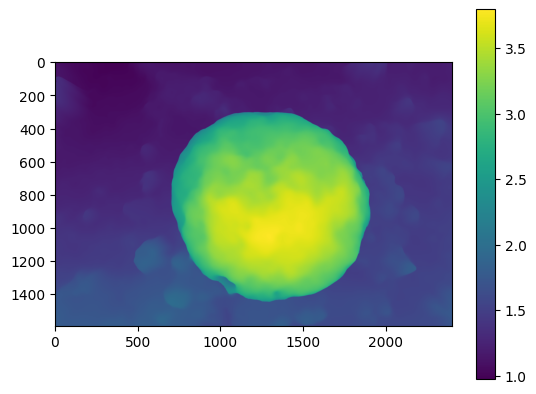

In [82]:
imshow(beta_d[:, :, 0])

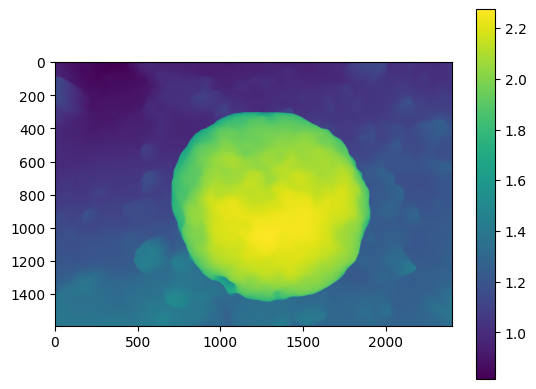

In [83]:
imshow(beta_d[:, :, 1])

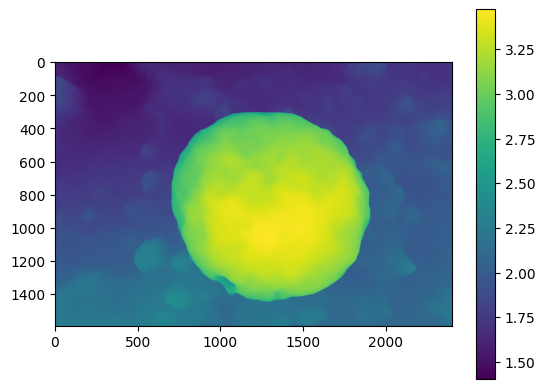

In [84]:
imshow(beta_d[:, :, 2])

In [85]:
(direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)).max()

np.float64(7.463869976756204)

In [86]:
(direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)).max()

np.float64(6.463473454418518)

In [87]:
(direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)).max()

np.float64(4.571025192190642)

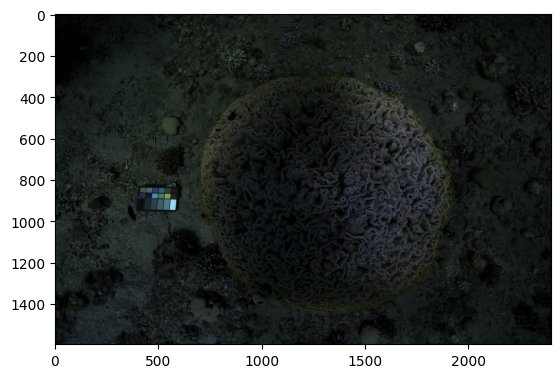

In [88]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

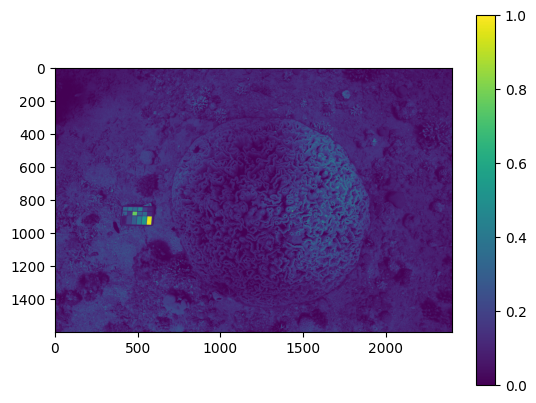

In [89]:
imshow(J[:, :, 0])

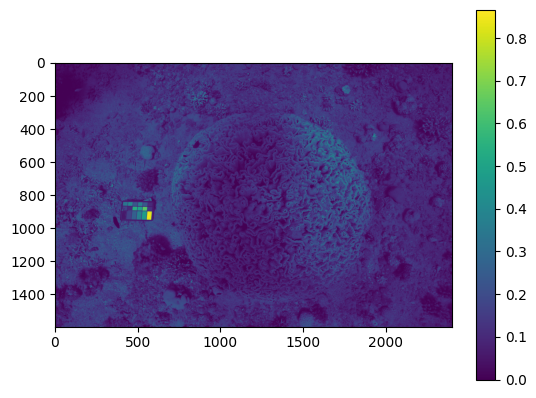

In [90]:
imshow(J[:, :, 1])

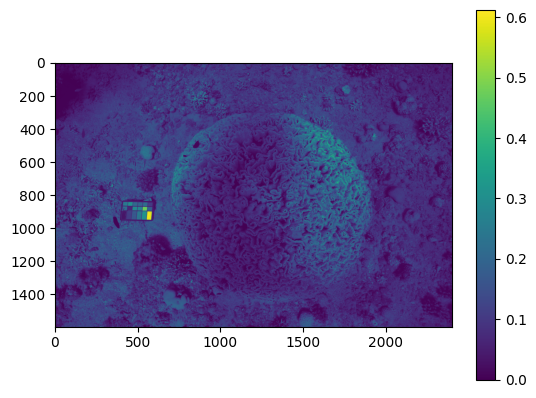

In [91]:
imshow(J[:, :, 2])

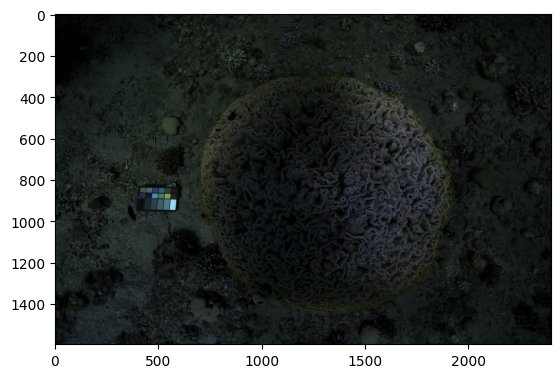

In [92]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [93]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [94]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

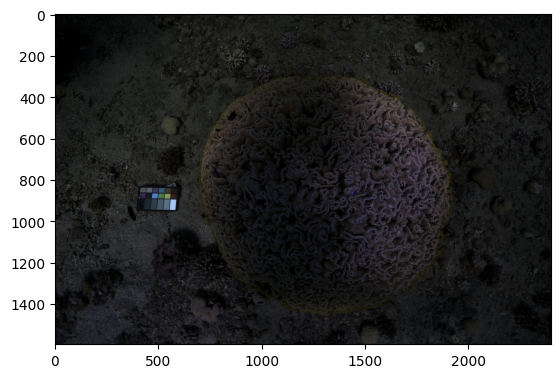

In [95]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [96]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

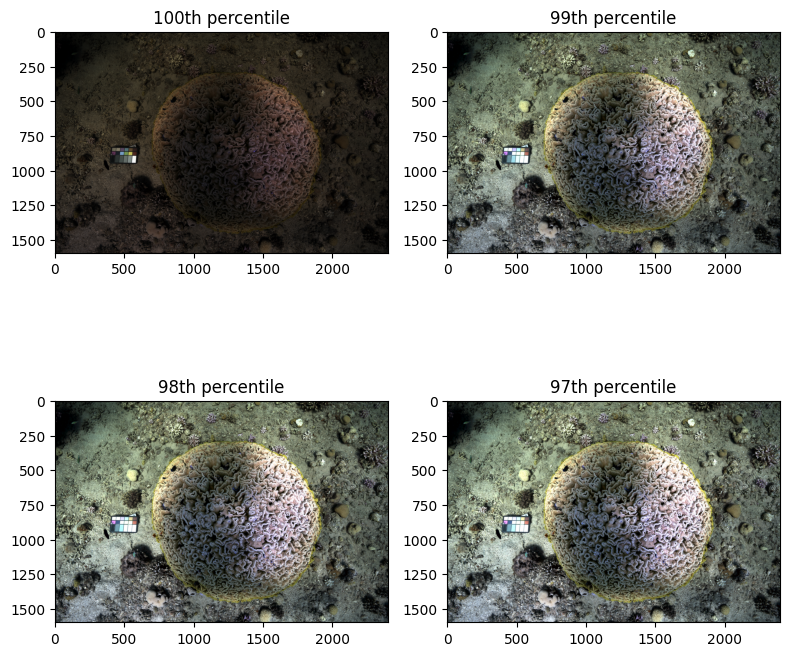

In [97]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

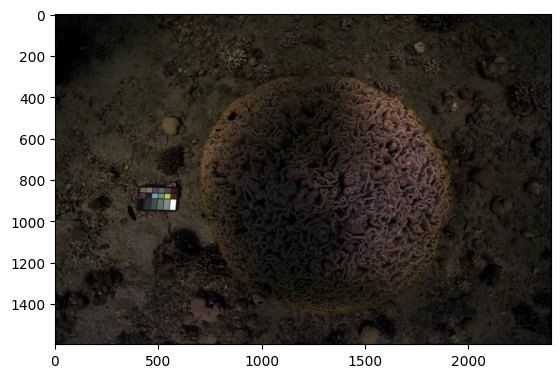

In [98]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

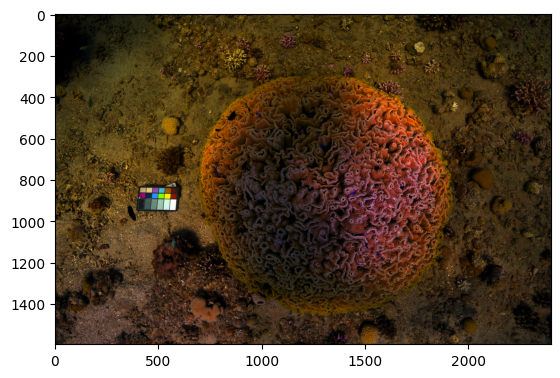

In [99]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

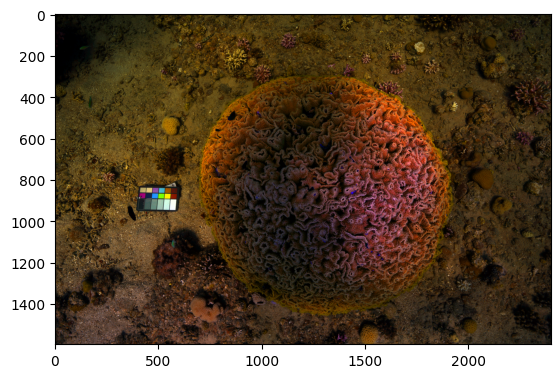

In [100]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

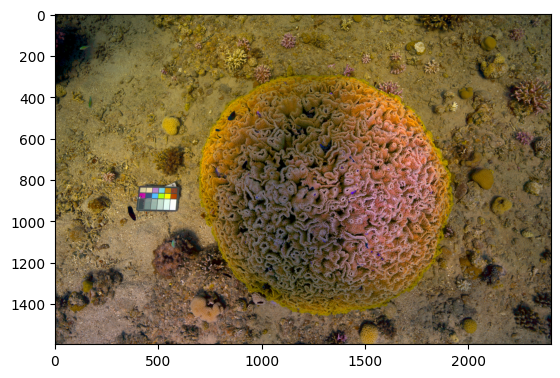

In [101]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

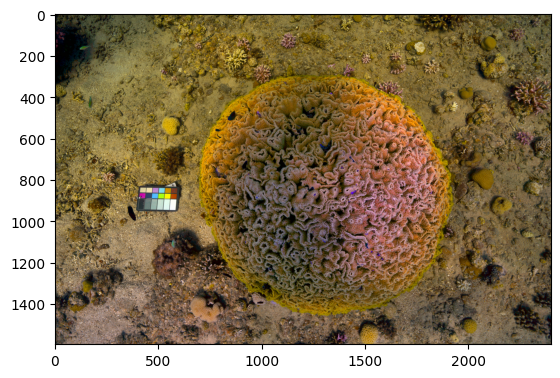

In [102]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [103]:
cv2.imwrite("output/crutchfield_perry_final.png", img_as_ubyte(img_hist))

True